In [1]:
!pip -q install -U transformers datasets accelerate scikit-learn
import numpy as np
import pandas as pd
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 11.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jan 20 17:04:19 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**Use dicts to safely inspect messy JSON-like records**

In [4]:
def read_json(filename, lines=False):


    open_fn = gzip.open if filename.endswith(".gz") else open

    if lines:
        data = []
        with open_fn(filename, "rt", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if line:
                    data.append(json.loads(line))
        return data  # <-- return AFTER the loop finishes

    else:
        with open_fn(filename, "rt", encoding="utf-8") as f:
            return json.load(f)



In [5]:
import gzip
import json


data = read_json("/content/drive/MyDrive/MSDS_marketing_text_analytics/master_files/1_text_classification/y__VHyJ0SgCIcxd9tNhazg_695452701c3c435691238d1b1c0016f1_news_category_trainingdata.json", lines=True)
data[0:3]


[{'category': {'0': 'CRIME',
   '1': 'ENTERTAINMENT',
   '2': 'ENTERTAINMENT',
   '3': 'ENTERTAINMENT',
   '4': 'ENTERTAINMENT',
   '5': 'ENTERTAINMENT',
   '6': 'ENTERTAINMENT',
   '7': 'ENTERTAINMENT',
   '8': 'ENTERTAINMENT',
   '9': 'ENTERTAINMENT',
   '10': 'ENTERTAINMENT',
   '11': 'WORLD NEWS',
   '12': 'IMPACT',
   '13': 'POLITICS',
   '14': 'POLITICS',
   '15': 'POLITICS',
   '16': 'POLITICS',
   '17': 'POLITICS',
   '18': 'POLITICS',
   '19': 'POLITICS',
   '20': 'WEIRD NEWS',
   '21': 'ENTERTAINMENT',
   '22': 'WEIRD NEWS',
   '23': 'WORLD NEWS',
   '24': 'WORLD NEWS',
   '25': 'WORLD NEWS',
   '26': 'WORLD NEWS',
   '27': 'BLACK VOICES',
   '28': 'BLACK VOICES',
   '29': 'BLACK VOICES',
   '30': 'POLITICS',
   '31': 'BLACK VOICES',
   '32': 'CRIME',
   '33': 'POLITICS',
   '34': 'ENTERTAINMENT',
   '35': 'WOMEN',
   '36': 'POLITICS',
   '37': 'COMEDY',
   '38': 'COMEDY',
   '39': 'COMEDY',
   '40': 'CRIME',
   '41': 'COMEDY',
   '42': 'CRIME',
   '43': 'ENTERTAINMENT',
   '

In [6]:
def unique_values(data, key):

  """Where `data` is a list of dictionaries which may or may not
    contain the key specified by `key`.

    purpose:scan a list of dictionaries and give you back all the
    different (unique) values it finds for one specific key.
    Show me all the different answers people gave for this field.

    Returns a list of the distinct item values for items keyed by
    `key`. Skips any data entries that do not contain that key.

    E.g.: Consider following data list:

    data =[
        { "product_type": "shoes", "color": "red" },
        { "product_type": "hats", "color": "blue" },
        { "product_type": "shoes", "size": "large" },
        { "product_type": "shoes", "color": "red" }
    ]

    The response for the call unique_values(data, "color") would be:

    [ "red", "blue" ]

    Noting that "red" is only included 1 time, and that none of "shoes",
    "hats", or "large" are values for which the key matches "color".
    """

    # TODO: Implement this function to return a list of the unique items
    #       in data keyed by key

  uniques = []

  for item in data:
        if key in item:
            value = item[key]
            if value not in uniques:
                uniques.append(value)

  return uniques

In [7]:
import datetime


def summary(data):

    """Returns a summary line of the data in a readable format."""
    category = data.get("category", "")
    article_date = data.get("date", "")
    headline = data.get("headline", "")

## DATE: "Mon YYYY" (e.g., "Jan 2022") — but don't crash if date is missing/bad
    date_str = ""
    if article_date:
        try:
            d = datetime.date.fromisoformat(article_date)  # YYYY-MM-DD
            date_str = d.strftime("%b, %Y")
        except ValueError:
            date_str = ""

    # CATEGORY: title case (e.g., "CRIME" -> "Crime")
    category_str = category.title() if category else ""

    # HEADLINE: truncate to 50 characters
    headline_str = headline[:50] if headline else ""

    return f"{date_str}. {category_str}. {headline_str}"


In [8]:
data = {
    'authors': 'Melissa Jeltsen',
    'category': 'CRIME',
    'date': '2018-05-26',
    'headline': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
    'link': 'https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89',
    'short_description': 'She left her husband. He killed their children. Just another day in America.'
}

In [9]:
unique_values([data], "category") # Note that we must pass in a list
#Show me all the different answers people gave for this field.

['CRIME']

In [10]:
summary(data)
#handles missing keys + safe date parsing + formatting + truncation

'May, 2018. Crime. There Were 2 Mass Shootings In Texas Last Week, Bu'

In [11]:
import pandas as pd

analyze = pd.read_json("/content/drive/MyDrive/MSDS_marketing_text_analytics/master_files/1_text_classification/y__VHyJ0SgCIcxd9tNhazg_695452701c3c435691238d1b1c0016f1_news_category_trainingdata.json")

**Inspecting & Prepareing the Data**

Most machine learning tools in Python accept one field/column/string. So we have to merge our two text column. Let's separate it with a space.

In [12]:
analyze.head()
len(analyze)

200853

In [13]:
analyze['combined_text'] = analyze['headline'] + ' ' + analyze['short_description']

In [14]:
analyze[analyze['category'].str.contains("HEALTHY LIVING")]

,category,headline,authors,link,short_description,date,combined_text
7578,HEALTHY LIVING,To The People Who Say ‘I’m Tired’ When Someone...,"The Mighty, ContributorWe face disability, dis...",https://www.huffingtonpost.com/entry/to-the-pe...,"When you feel like this, it’s important to kno...",2018-01-16,To The People Who Say ‘I’m Tired’ When Someone...
7693,HEALTHY LIVING,Eating Shake Shack Made Me Feel Healthier Than...,"Colleen Werner, ContributorCampus Editor-at-Large",https://www.huffingtonpost.com/entry/eating-sh...,I can vividly remember the first time I felt f...,2018-01-12,Eating Shake Shack Made Me Feel Healthier Than...
7747,HEALTHY LIVING,How To Stay Updated On The News Without Losing...,Lindsay Holmes,https://www.huffingtonpost.com/entry/anxiety-f...,Because it's only becoming more of a struggle.,2018-01-12,How To Stay Updated On The News Without Losing...
7927,HEALTHY LIVING,27 Perfect Tweets About Whole30 That Will Make...,Lindsay Holmes,https://www.huffingtonpost.com/entry/tweets-ab...,"""The only Whole30 I want to participate in is ...",2018-01-10,27 Perfect Tweets About Whole30 That Will Make...
7934,HEALTHY LIVING,The Real Reason Your Hands Are Always Cold,"Refinery29, ContributorThe #1 new-media brand ...",https://www.huffingtonpost.com/entry/the-real-...,"Essentially, your hands are kept warm thanks t...",2018-01-10,The Real Reason Your Hands Are Always Cold Ess...
...,...,...,...,...,...,...,...
124913,HEALTHY LIVING,Why You Need Both a 'Bouncer' and a 'Bartender...,"Elizabeth Grace Saunders, ContributorFounder, ...",https://www.huffingtonpost.com/entry/happy-hea...,Instead of judging whether you made the right ...,2014-04-18,Why You Need Both a 'Bouncer' and a 'Bartender...
124914,HEALTHY LIVING,How Video Games Can Improve Dialogue on Mental...,"Mona Shattell, Contributornurse researcher",https://www.huffingtonpost.com/entry/mental-il...,While there are strong arguments for the games...,2014-04-18,How Video Games Can Improve Dialogue on Mental...
124925,HEALTHY LIVING,Wake-Up Calls Inspired My Change From Overdriv...,"Jane Shure, ContributorLeadership Coach, Psych...",https://www.huffingtonpost.com/entry/wake-up-c...,My wake-up call marching orders were clear: No...,2014-04-18,Wake-Up Calls Inspired My Change From Overdriv...
124950,HEALTHY LIVING,Loving a Narcissist Without Losing Yourself,"Nancy Colier, ContributorPsychotherapist, inte...",https://www.huffingtonpost.com/entry/narcissis...,It is very difficult for some people to see an...,2014-04-18,Loving a Narcissist Without Losing Yourself It...


A quick check in pandas shows we have about 6,694 articles in the “Healthy Living” category. The next line uses NumPy’s where like an if/else rule to create a new label column. If an article’s category is "Healthy Living", we set healthy = 1 (meaning “yes, it’s healthy”). If it’s anything else, we set healthy = 0 (meaning “no”).

In [15]:
import numpy as np
analyze['healthy'] = np.where((analyze['category'] == 'HEALTHY LIVING'), 1, 0)

In [16]:
analyze['healthy'].describe()

,healthy
count,200853.000000
mean,0.033328
std,0.179492
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


The dataset has very few **Healthy Living** articles compared to everything else. Out of every 100 articles, only about 3 are labeled **healthy** and the other 97 are labeled **not healthy**. Because the data is so uneven, a model can look like it’s doing well just by guessing **not healthy** most of the time, even if it barely catches any of the **healthy** articles. That’s why accuracy by itself can be misleading. Iu want to also look at how well the model actually finds the healthy articles.This dataset is clearly **unbalanced**.

In [17]:
sample_amount =  len(analyze[analyze["healthy"] == 1])

healthy = analyze[analyze['healthy'] == 1]
not_healthy = analyze[analyze['healthy'] == 0].sample(n=sample_amount)
print(sample_amount)

review_sample = pd.concat([healthy,not_healthy])
len(review_sample)

6694


13388

In [34]:
review_sample.head()

,category,headline,authors,link,short_description,date,combined_text,healthy
7578,HEALTHY LIVING,To The People Who Say ‘I’m Tired’ When Someone...,"The Mighty, ContributorWe face disability, dis...",https://www.huffingtonpost.com/entry/to-the-pe...,"When you feel like this, it’s important to kno...",2018-01-16,To The People Who Say ‘I’m Tired’ When Someone...,1
7693,HEALTHY LIVING,Eating Shake Shack Made Me Feel Healthier Than...,"Colleen Werner, ContributorCampus Editor-at-Large",https://www.huffingtonpost.com/entry/eating-sh...,I can vividly remember the first time I felt f...,2018-01-12,Eating Shake Shack Made Me Feel Healthier Than...,1
7747,HEALTHY LIVING,How To Stay Updated On The News Without Losing...,Lindsay Holmes,https://www.huffingtonpost.com/entry/anxiety-f...,Because it's only becoming more of a struggle.,2018-01-12,How To Stay Updated On The News Without Losing...,1
7927,HEALTHY LIVING,27 Perfect Tweets About Whole30 That Will Make...,Lindsay Holmes,https://www.huffingtonpost.com/entry/tweets-ab...,"""The only Whole30 I want to participate in is ...",2018-01-10,27 Perfect Tweets About Whole30 That Will Make...,1
7934,HEALTHY LIVING,The Real Reason Your Hands Are Always Cold,"Refinery29, ContributorThe #1 new-media brand ...",https://www.huffingtonpost.com/entry/the-real-...,"Essentially, your hands are kept warm thanks t...",2018-01-10,The Real Reason Your Hands Are Always Cold Ess...,1


The syntax above first counts how many **healthy** articles the dataset has by filtering the dataset to rows where healthy == 1 and taking the length, then it stores all of those healthy rows in a healthy dataset. After that, it takes the much larger **not healthy** group (healthy == 0) and randomly picks the same number of rows (sample_amount) from it to create **not_healthy**. The reason for doing this is to make a more balanced dataset (roughly 50/50 healthy vs not healthy) so the model doesn’t just learn to guess **not healthy** all the time because that class is much more common.

Then I append the two datasets,  **healthy and not_healthy**  into one new dataset called **review_sample**. The goal is to create a balanced dataset with about the same number of healthy and not-healthy articles.  **len(review_sample)**, prints how many total rows are now in that combined dataset.

In [18]:
review_sample.describe()

,date,healthy
count,13388,13388.000000
mean,2015-06-16 17:38:35.745443840,0.500000
min,2012-01-28 00:00:00,0.000000
25%,2014-06-30 00:00:00,0.000000
50%,2015-05-15 00:00:00,0.500000
75%,2016-09-27 00:00:00,1.000000
max,2018-05-25 00:00:00,1.000000
std,NaN,0.500019


If the average (`mean`) of the **healthy** column is **0.5**, that means **half the rows are labeled 1 (healthy)** and **half are labeled 0 (not healthy)**, so the dataset is balanced. The **N** (total number of rows) is **twice the number of healthy articles** because you included **all the healthy articles** and then added an **equal-sized sample** of not-healthy articles.


Deep learning

Next, we prepare the data for the BERT model, setting a maximum token length and splitting the data into training and validation sets.

In [19]:
target_names = ['NOT HEALTHY LIVING','HEALTHY LIVING']

In [20]:


!pip -q install -U transformers datasets accelerate scikit-learn

import os
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["USE_TF"] = "0"

import numpy as np
import pandas as pd
import torch
from datasets import Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

# keep only what we need
# remove missing
df = review_sample[["combined_text", "healthy"]].dropna().copy()
df["healthy"] = df["healthy"].astype(int)

# train/val split (val_pct=0.1)
train_df = df.sample(frac=0.9, random_state=42)
val_df   = df.drop(train_df.index)

# tokenizer (preprocess_mode="distilbert")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", use_fast=True)

def tokenize(batch):
    return tokenizer(batch["combined_text"], truncation=True, max_length=512)

train = Dataset.from_pandas(train_df.reset_index(drop=True)).map(tokenize, batched=True)
val   = Dataset.from_pandas(val_df.reset_index(drop=True)).map(tokenize, batched=True)

# HF expects label column named "labels"
train = train.rename_column("healthy", "labels")
val   = val.rename_column("healthy", "labels")

# dynamic padding (faster than padding to 512 for every example)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

preprocess = {"tokenizer": tokenizer}  # ktrain-like placeholder


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/12049 [00:00<?, ? examples/s]

Map:   0%|          | 0/1339 [00:00<?, ? examples/s]

In this step, I set up my text data so a transformer **model (DistilBERT)** can learn from it. First, I install the **Hugging Face** tools I need, then I tell the environment to use the **PyTorch** version of transformers (and ignore TensorFlow) to avoid compatibility issues.

Next, I take my dataset **(review_sample)** and keep only the two columns I need: **the article text (combined_text)** and **the label (healthy)**. I remove any missing rows and make sure the label is stored as an integer (0 or 1).

After that, I split the data into two parts: 90% for **training (what the model learns from)** and **10% for validation (what I use to test how well it learned)**. Then I load **DistilBERT’s tokenizer**, which converts each article into the numbered tokens the model understands. I also set a maximum length of **512** tokens, so longer articles are cut off and shorter ones are padded to the same size.

Finally, I convert the training and validation data into the format expected by the model by renaming the label column to labels and keeping only the exact inputs the transformer needs **(input_ids, attention_mask, and labels)** for training.

In [21]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
from sklearn.metrics import accuracy_score
from transformers import TrainingArguments, Trainer

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, preds)}

training_args = TrainingArguments(
    output_dir="checkpoint",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=1e-4,
    num_train_epochs=10,

    eval_strategy="epoch",
    save_strategy="epoch",

    logging_strategy="steps",
    logging_steps=50,

    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
    fp16=torch.cuda.is_available(),   # speed-up on GPU
)



In [24]:
learner = Trainer(
    model=model,
    args=training_args,
    train_dataset=train,
    eval_dataset=val,
    tokenizer=preprocess["tokenizer"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


/tmp/ipython-input-337959962.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  learner = Trainer(


In [26]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

lrs = [5e-6, 1e-5, 2e-5, 5e-5, 1e-4]
results = []

for lr in lrs:
    args = TrainingArguments(
        output_dir=f"checkpoint_lr_{lr}",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        learning_rate=lr,
        num_train_epochs=1,
        eval_strategy="epoch",
        save_strategy="no",          # don't waste time saving during the sweep
        logging_strategy="steps",
        logging_steps=50,
        report_to="none",
        fp16=torch.cuda.is_available(),
    )

    tmp = Trainer(
        model=AutoModelForSequenceClassification.from_pretrained(
            "distilbert-base-uncased", num_labels=2
        ),
        args=args,
        train_dataset=train,
        eval_dataset=val,
        tokenizer=preprocess["tokenizer"],
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    tmp.train()
    metrics = tmp.evaluate()
    results.append((lr, metrics["eval_accuracy"], metrics["eval_loss"]))

results


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2452845576.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tmp = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.397200,0.395496,0.837939


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2452845576.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tmp = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.370000,0.371932,0.846154


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2452845576.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tmp = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.358600,0.355309,0.852128


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2452845576.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tmp = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.346500,0.336245,0.855863


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2452845576.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tmp = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.345200,0.324608,0.867812


[(5e-06, 0.8379387602688574, 0.3954956531524658),
 (1e-05, 0.8461538461538461, 0.37193161249160767),
 (2e-05, 0.8521284540702017, 0.35530874133110046),
 (5e-05, 0.8558625840179238, 0.33624541759490967),
 (0.0001, 0.8678117998506348, 0.32460761070251465)]

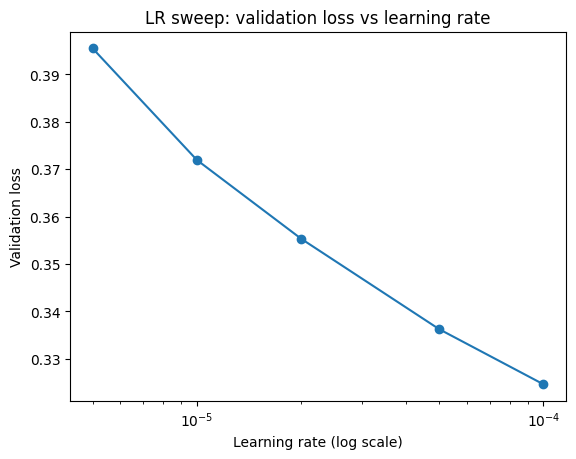

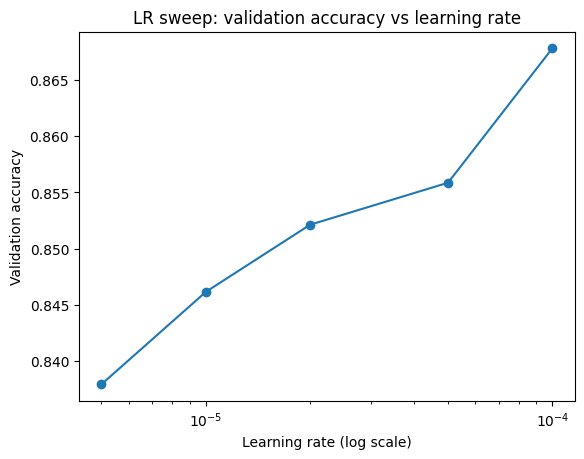

In [32]:
import matplotlib.pyplot as plt

# results should look like: [(lr, eval_acc, eval_loss), ...]
lrs_plot  = [r[0] for r in results]
acc_plot  = [r[1] for r in results]
loss_plot = [r[2] for r in results]

plt.figure()
plt.semilogx(lrs_plot, loss_plot, marker="o")
plt.xlabel("Learning rate (log scale)")
plt.ylabel("Validation loss")
plt.title("LR sweep: validation loss vs learning rate")
plt.show()

plt.figure()
plt.semilogx(lrs_plot, acc_plot, marker="o")
plt.xlabel("Learning rate (log scale)")
plt.ylabel("Validation accuracy")
plt.title("LR sweep: validation accuracy vs learning rate")
plt.show()


These two plots are showing us how the model’s performance changes when we try different learning rates (how “big” each training update step is).

In the **top plot**, the validation loss steadily goes down as the learning rate gets larger, which is good. **Lower loss** means the model is making fewer mistakes on the **validation data**.

In the **bottom plot**, the validation accuracy steadily goes up as the learning rate increases, which is also good. **Higher accuracy** means the model is correctly labeling more articles. Since both plots improve in the same direction, this tells us that the larger learning rate I tested **(around 1e-4)** worked best out of the options I tried, because it gave the lowest validation loss and the highest validation accuracy.

In [28]:
from transformers.trainer_callback import EarlyStoppingCallback

learner.add_callback(EarlyStoppingCallback(early_stopping_patience=2))
history = learner.train()


You are adding a <class 'transformers.trainer_callback.EarlyStoppingCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
NotebookProgressCallback
EarlyStoppingCallback


Epoch,Training Loss,Validation Loss,Accuracy
1,0.395800,0.386023,0.843913
2,0.240500,0.457564,0.862584
3,0.108600,0.549599,0.846901
4,0.071400,0.689918,0.846154


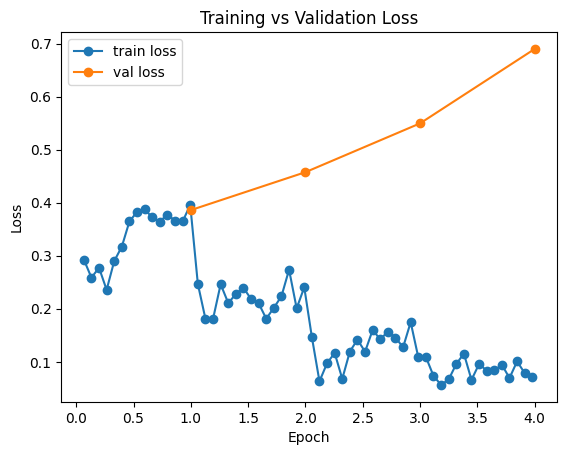

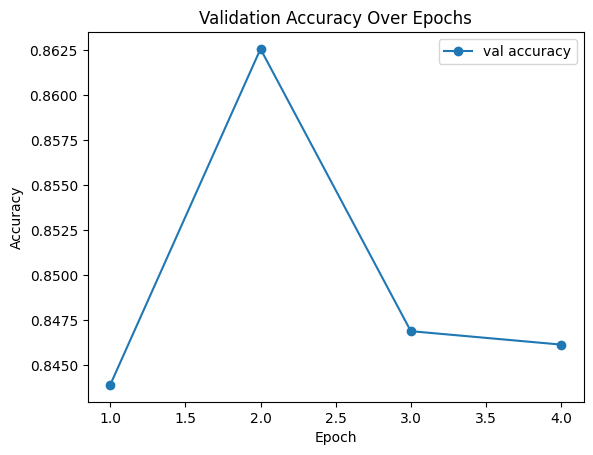

In [33]:
import matplotlib.pyplot as plt

logs = learner.state.log_history
train_loss = [(x["epoch"], x["loss"]) for x in logs if "loss" in x and "epoch" in x and "eval_loss" not in x]
eval_loss  = [(x["epoch"], x["eval_loss"]) for x in logs if "eval_loss" in x and "epoch" in x]
eval_acc   = [(x["epoch"], x["eval_accuracy"]) for x in logs if "eval_accuracy" in x and "epoch" in x]

# Loss plot
plt.figure()
if train_loss:
    plt.plot([e for e,_ in train_loss], [v for _,v in train_loss], marker="o", label="train loss")
if eval_loss:
    plt.plot([e for e,_ in eval_loss], [v for _,v in eval_loss], marker="o", label="val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training vs Validation Loss")
plt.legend(); plt.show()

# Accuracy plot (validation only, unless you also compute train acc separately)
plt.figure()
if eval_acc:
    plt.plot([e for e,_ in eval_acc], [v for _,v in eval_acc], marker="o", label="val accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Validation Accuracy Over Epochs")
plt.legend(); plt.show()


These plots are showing a classic sign of **overfitting**. In the first chart, the **training loss (blue line)** keeps going down, which means the model is getting better and better at predicting the training articles it learned from. But at the same time, the **validation loss (orange line)** keeps going up each epoch, which means the model is getting worse on new, unseen articles. In the second chart, the validation accuracy improves at first and peaks around **epoch 2**, but then it drops and stays lower after that. Put together, this means the model starts out learning useful patterns, but after about 2 epochs it begins to **“memorize” the training data** instead of learning general rules that work on new data. The best checkpoint is likely around epoch 2, and that’s why **early stopping (stopping when validation stops improving)** is important here.

In [29]:
def predictor(texts):
    if isinstance(texts, str):
        texts = [texts]
    enc = preprocess["tokenizer"](texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
    enc = {k: v.to(model.device) for k, v in enc.items()}
    with torch.no_grad():
        out = learner.model(**enc)
        probs = torch.softmax(out.logits, dim=-1).cpu().numpy()
        preds = probs.argmax(axis=1)
    return preds, probs


In [30]:
!pip -q install -U scikit-learn
from sklearn.metrics import classification_report, confusion_matrix

pred = learner.predict(val)
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=1)

target_names = ['NOT HEALTHY LIVING','HEALTHY LIVING']
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))


                    precision    recall  f1-score   support

NOT HEALTHY LIVING     0.8794    0.8430    0.8608       675
    HEALTHY LIVING     0.8468    0.8825    0.8643       664

          accuracy                         0.8626      1339
         macro avg     0.8631    0.8627    0.8626      1339
      weighted avg     0.8633    0.8626    0.8625      1339

Confusion matrix:
 [[569 106]
 [ 78 586]]


This report is telling us how well the model can separate **NOT HEALTHY LIVING** articles from **HEALTHY LIVING** articles on the validation set (1,339 total articles). Overall, it’s correct about **86%** of the time (accuracy = 0.8626), which is pretty solid. For **NOT HEALTHY LIVING**, the model is right about **88%** of the time when it predicts that label (precision = 0.8794), and it successfully catches about **84%** of all the not-healthy articles that were truly not-healthy (recall = 0.8430). For **HEALTHY LIVING**, when the model predicts healthy it’s right about **85%** of the time (precision = 0.8468), and it correctly finds about **88%** of the truly healthy articles (recall = 0.8825). The **confusion matrix** shows the exact counts: it correctly labeled **569 not-healthy** and **586 healthy**, but it made **106 “false alarms”** where it called something healthy when it wasn’t, and **78 misses** where it failed to catch a healthy article and labeled it not-healthy.

In [31]:
import torch
import numpy as np

test_docs = [
    "Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.",
    "Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.",
    "What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.",
    "Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.",
    "Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The district attorney described the woman who said former Gov. Andrew Cuomo had groped her as “credible,” but added that proving her allegation would be difficult.",
    "A Film Captures Jewish Life in a Polish Town Before the Nazis Arrived. A documentary based on a home movie shot by an American in 1938 provides a look at the vibrancy of a Jewish community in Europe just before the Holocaust."
]

label_names = {0: "NOT HEALTHY LIVING", 1: "HEALTHY LIVING"}

def predict_proba(texts):
    if isinstance(texts, str):
        texts = [texts]
    enc = preprocess["tokenizer"](texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
    enc = {k: v.to(learner.model.device) for k, v in enc.items()}

    with torch.no_grad():
        logits = learner.model(**enc).logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()

    preds = probs.argmax(axis=1)
    return preds, probs

for i, txt in enumerate(test_docs):
    pred, probs = predict_proba(txt)
    healthy_prob = probs[0][1]
    print("---------------------------")
    print(f"Pred: {label_names[int(pred[0])]} | P(HEALTHY LIVING) = {healthy_prob:.4f}")
    print(txt)


---------------------------
Pred: HEALTHY LIVING | P(HEALTHY LIVING) = 0.9665
Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.
---------------------------
Pred: HEALTHY LIVING | P(HEALTHY LIVING) = 0.9741
Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.
---------------------------
Pred: HEALTHY LIVING | P(HEALTHY LIVING) = 0.9744
What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.
---------------------------
Pred: HEALTHY LIVING | P(HEALTHY LIVING) = 0.8472
Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.
---------------------------
Pred: NOT HEALTHY LIVING | P(HEALTHY LIVING) = 0.0027
Cuomo Will Not Be Prosecuted in Groping Cas

This section is a  “sanity check” that shows how the trained model behaves on a few brand-new article headlines and descriptions. For each example article, we run it through the predictor and print the probability that the model thinks the article belongs to the **Healthy Living category**. A higher probability means the model is more confident the text sounds like **Healthy Living (things like exercise, diet, wellness, stress/health topics)**, while a lower probability means it thinks the text is probably not **Healthy Living (like politics, crime, or history)**. Seeing these probabilities next to the actual text helps us confirm the model is making reasonable predictions and not just guessing randomly.

# **Comparing Traditional ML Models for Text Classification**


In [37]:
from sklearn.model_selection import train_test_split


#Same dataset + same label
df = review_sample[["combined_text", "healthy"]].dropna().copy()
df["healthy"] = df["healthy"].astype(int)

# 80% train_temp, 20% test (FINAL HOLDOUT)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    df["combined_text"],
    df["healthy"],
    test_size=0.2,
    random_state=42,
    stratify=df["healthy"]
)


# from the 80%, carve out 10% validation (so 72/8/20 overall)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp, y_train_temp,
    test_size=0.1, random_state=42, stratify=y_train_temp
)

#DataFrames for HF Datasets
train_df = pd.DataFrame({"combined_text": X_train.values, "labels": y_train.values})
val_df   = pd.DataFrame({"combined_text": X_val.values,   "labels": y_val.values})
test_df  = pd.DataFrame({"combined_text": X_test.values,  "labels": y_test.values})


#Tokenize using the same text column ---
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", use_fast=True)

def tokenize(batch):
    return tokenizer(batch["combined_text"], truncation=True, max_length=512)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True, remove_columns=["combined_text"])
val_ds   = Dataset.from_pandas(val_df).map(tokenize,   batched=True, remove_columns=["combined_text"])
test_ds  = Dataset.from_pandas(test_df).map(tokenize,  batched=True, remove_columns=["combined_text"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/9639 [00:00<?, ? examples/s]

Map:   0%|          | 0/1071 [00:00<?, ? examples/s]

Map:   0%|          | 0/2678 [00:00<?, ? examples/s]

In [38]:
import numpy as np
from sklearn.metrics import accuracy_score
from transformers import AutoModelForSequenceClassification

id2label = {0: "NOT HEALTHY LIVING", 1: "HEALTHY LIVING"}
label2id = {v:k for k,v in id2label.items()}

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, preds)}

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
import inspect

# TrainingArguments (handles eval_strategy vs evaluation_strategy) ---
sig = inspect.signature(TrainingArguments.__init__)
args = dict(
    output_dir="checkpoint",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=1e-4,
    num_train_epochs=10,
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
    fp16=torch.cuda.is_available(),
)
if "evaluation_strategy" in sig.parameters:
    args["evaluation_strategy"] = "epoch"
else:
    args["eval_strategy"] = "epoch"

training_args = TrainingArguments(**args)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,        # ✅ use validation during training
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.400400,0.400770,0.828198
2,0.275100,0.425116,0.847806
3,0.264500,0.539397,0.846872
4,0.137400,0.551143,0.847806
5,0.082400,0.789693,0.842204
6,0.072000,0.811229,0.856209
7,0.053400,0.958053,0.850607
8,0.020900,1.043027,0.846872
9,0.016600,1.092829,0.850607
10,0.029100,1.121892,0.849673


TrainOutput(global_step=6030, training_loss=0.12496365433246837, metrics={'train_runtime': 527.6915, 'train_samples_per_second': 182.664, 'train_steps_per_second': 11.427, 'total_flos': 1956640758895008.0, 'train_loss': 0.12496365433246837, 'epoch': 10.0})

In [41]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# --- Report on FINAL holdout test set ---
pred = trainer.predict(test_ds)

y_pred = np.argmax(pred.predictions, axis=1)
y_true = pred.label_ids

target_names = ["NOT HEALTHY LIVING", "HEALTHY LIVING"]
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))


                    precision    recall  f1-score   support

NOT HEALTHY LIVING     0.8550    0.8454    0.8502      1339
    HEALTHY LIVING     0.8471    0.8566    0.8518      1339

          accuracy                         0.8510      2678
         macro avg     0.8511    0.8510    0.8510      2678
      weighted avg     0.8511    0.8510    0.8510      2678

Confusion matrix:
 [[1132  207]
 [ 192 1147]]


In [49]:
# TF-IDF (fit on train only)

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words="english")
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)


In [50]:
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics



#  Classic models
classifiers = [
    (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
    (LinearSVC(penalty="l2", dual=False, tol=1e-3), "Linear SVC"),
    (SGDClassifier(alpha=1e-4, max_iter=1000, penalty="l2"), "SGD (linear)"),
    (MultinomialNB(alpha=0.01), "Multinomial NB"),
]


In [51]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# --- Classic models ---
results = []
for clf, name in classifiers:
    clf.fit(X_train_tfidf, y_train)
    y_pred = clf.predict(X_test_tfidf)

    results.append({
        "Classifier": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, pos_label=1),
        "Recall": recall_score(y_test, y_pred, pos_label=1),
        "F1": f1_score(y_test, y_pred, pos_label=1),
    })

results_df = pd.DataFrame(results)

# --- HF model on SAME test set ---
p = trainer.predict(test_ds)
y_true = p.label_ids
y_pred = np.argmax(p.predictions, axis=1)

results_df = pd.concat(
    [results_df,
     pd.DataFrame([{
         "Classifier": "DistilBERT (Hugging Face)",
         "Accuracy": accuracy_score(y_true, y_pred),
         "Precision": precision_score(y_true, y_pred, pos_label=1),
         "Recall": recall_score(y_true, y_pred, pos_label=1),
         "F1": f1_score(y_true, y_pred, pos_label=1),
     }])],
    ignore_index=True
)

results_df = results_df.sort_values("F1", ascending=False).reset_index(drop=True)
results_df


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_ridge.py:953: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


,Classifier,Accuracy,Precision,Recall,F1
0,DistilBERT (Hugging Face),0.851008,0.847120,0.856609,0.851838
1,SGD (linear),0.818521,0.804425,0.841673,0.822628
2,Ridge Classifier,0.814414,0.809559,0.822255,0.815858
3,Linear SVC,0.808813,0.802045,0.820015,0.810931
4,Multinomial NB,0.789022,0.778417,0.808066,0.792964


**DistilBERT (Hugging Face) **was the best-performing classifier in this comparison for classifying news articles as **HEALTHY LIVING vs NOT HEALTHY LIVING**. It achieved an **accuracy of 0.851**, meaning it correctly classified about **85%** of the articles overall. While accuracy is a useful summary, the main priority for this project is **finding the HEALTHY LIVING articles**, so the most important metric is **recall **for the **HEALTHY LIVING class (how many truly healthy articles the model successfully catches)**. DistilBERT’s HEALTHY LIVING recall is **0.8518**, which means it correctly identifies about 85 out of every 100 healthy articles in the test set.

**Accuracy **is the percent of total predictions the model got right. **Precision answers, “When the model predicts HEALTHY LIVING, how often is it correct?”** and DistilBERT’s HEALTHY LIVING **precision is 0.8566**, meaning most articles it labels as healthy really are healthy (fewer false alarms). **Recall** answers, **“Out of all truly HEALTHY LIVING articles, how many did the model catch?”**, and since that’s the project focus, the **0.8518** recall is the key takeaway (fewer missed healthy articles). **F1** is a single score that **balances** precision and recall; for HEALTHY LIVING, the **F1 is 0.8471**, showing a strong overall balance while still keeping recall high.
Compared to the traditional machine learning baselines, DistilBERT was clearly ahead.

The next best model, **SGD (linear)**, reached 0.819 accuracy and 0.823 F1, while **Ridge Classifier** and **Linear SVC** were slightly lower (around 0.81 accuracy and 0.811–0.816 F1). These models are solid baselines because they’re typically faster and simpler, but they didn’t match DistilBERT’s performance on this language task. **Multinomial Naive Bayes** had the weakest results (0.789 accuracy, 0.793 F1), which often happens because it relies on simpler assumptions about text and doesn’t capture context the way transformer-based models do.

Overall, the results suggest that **DistilBERT** is the most reliable choice for this project because it delivers the best overall performance and, most importantly, it does a strong job catching HEALTHY LIVING articles (high recall) without creating too many incorrect “healthy” predictions (high precision).